In [1]:
import sys
sys.path.append("..")
import library

%load_ext line_profiler

In [2]:
# Imports for calibration TODO to be moved
import mergedeep
import copy

# General Imports
import os
import time
import numpy as np
import pandas as pd
import ipywidgets
import cv2

import matplotlib.pyplot as plt
from PIL import Image

# Display & Camera imports
from library.hardware import DispUtils
from library.hardware.DisplayGL import DisplayGL
from library.hardware.PylonCamera import PylonCamera

# Select GPU as device if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
%matplotlib inline

Using device: cuda


In [3]:
def bgr8_to_jpeg(frame, quality=75):
    return bytes(cv2.imencode('.jpg', frame, [cv2.IMWRITE_JPEG_QUALITY, quality])[1])

def update_widget(img_widget, value):
    img_widget.value = bgr8_to_jpeg(value)
    
img_widget = ipywidgets.Image(format='jpeg', value=bgr8_to_jpeg(np.zeros((1,1))), width=640, height=480)

**Setup Camera and SLM**

In [4]:
#Initializes the SLM
uD = DisplayGL(1, reverseX=False, reverseY=False)
slm = DisplayGL(2, reverseX=False, reverseY=False)

Using GLFW: 3.4.0 Wayland X11 GLX Null EGL OSMesa monotonic shared


In [5]:
cam_dev = PylonCamera('40308273')
cam_dev.configure(exposure=12000, trigLine="Line2", triggerDelay=2000, frameRate=120, reverseX=True, reverseY=False)
cam_dev.start(screens=[uD, slm])

Camera devices ID found: ['40266943', '40308273']
Camera devices ID found: ['40266943', '40308273']


### Simple test

In [8]:
# create image
pattern_size = 80
height, width = uD.get_screen_size()
asymetrical = False

# Typical checkboard pattern like
image = np.zeros((height, width))
a = np.vstack([np.ones((pattern_size, pattern_size)), np.zeros((pattern_size, pattern_size))])
b = np.abs(a-1)
c = np.hstack([a, b])
d = np.tile(c,(6,6))

sh, sw = np.shape(d)[0]//2, np.shape(d)[1]//2
image[height//2-sh:height//2+sh, width//2-sw:width//2+sw] = d

if(asymetrical):
    # Add some non symmetrical element
    d = np.tile(c,(2,1))
    sh, sw = np.shape(d)[0]//2, np.shape(d)[1]//2

    image_r = np.zeros((height, width))
    image_r[height//2-sh:height//2+sh, width//2-sw:width//2+sw] = d
    image_r = image + shift(rotate(image_r, angle=-45, reshape=False), (-2*pattern_size, -2*pattern_size))

    image_r = 1*(np.array(image_r > 0.5))
    image[:,:] = image_r[:,:]
    
image2 = image.copy() #  Look better on the SLM

In [9]:
#image = np.zeros((height, width))
img = Image.open("./data/physics_cat.jpg").convert('L')
img = np.array(img)/255
image = np.zeros((height, width))
image[(height - img.shape[0])//2:(height + img.shape[0])//2, (width - img.shape[1])//2:(width + img.shape[1])//2] = img

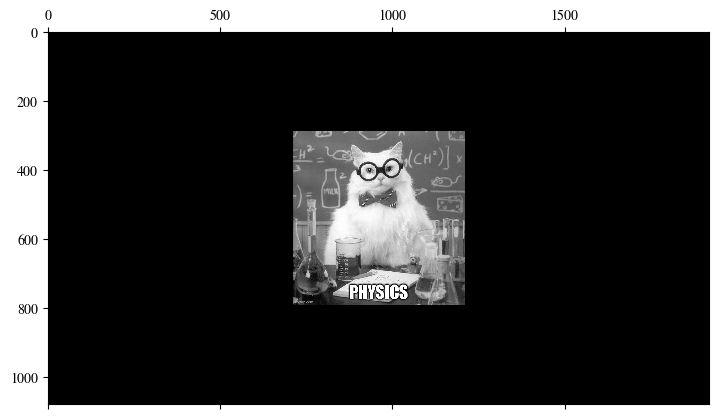

In [10]:
plt.matshow(image, cmap='gray')
plt.show()

In [11]:
%%time
slm.set_render_ready(False)
uD.set_render_ready(False)
slm.display(np.array([image, image*0.5]), sync_frame=True, CUDA2GL=False, scaling=127)
uD.display(np.array([image, image]), sync_frame=True, CUDA2GL=False)

pic = cam_dev.capture_image(2, sync_frame=True, remove_ref=False)

CPU times: user 197 ms, sys: 166 ms, total: 364 ms
Wall time: 201 ms


In [12]:
slm.set_render_ready(False)
uD.set_render_ready(False)
slm.display(image, sync_frame=True, CUDA2GL=False, scaling=127)
uD.display(image, sync_frame=True, CUDA2GL=False)

pic2 = cam_dev.capture_image(sync_frame=True, remove_ref=True)

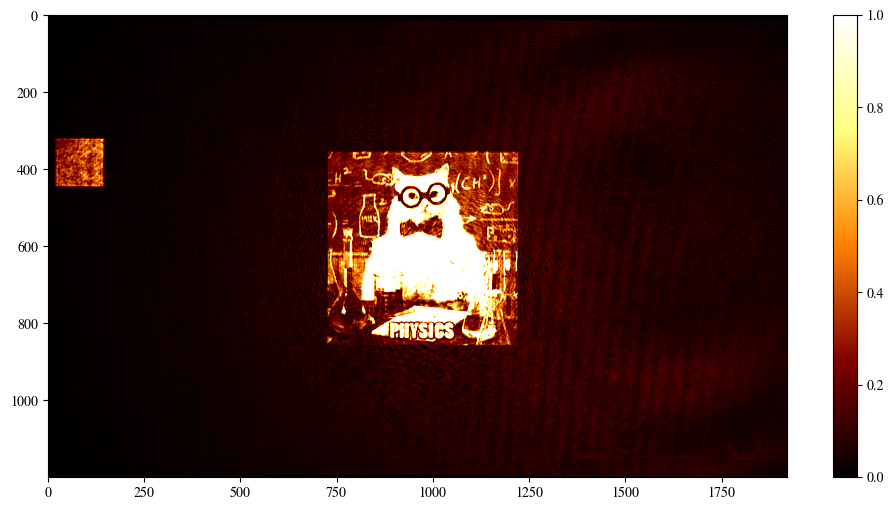

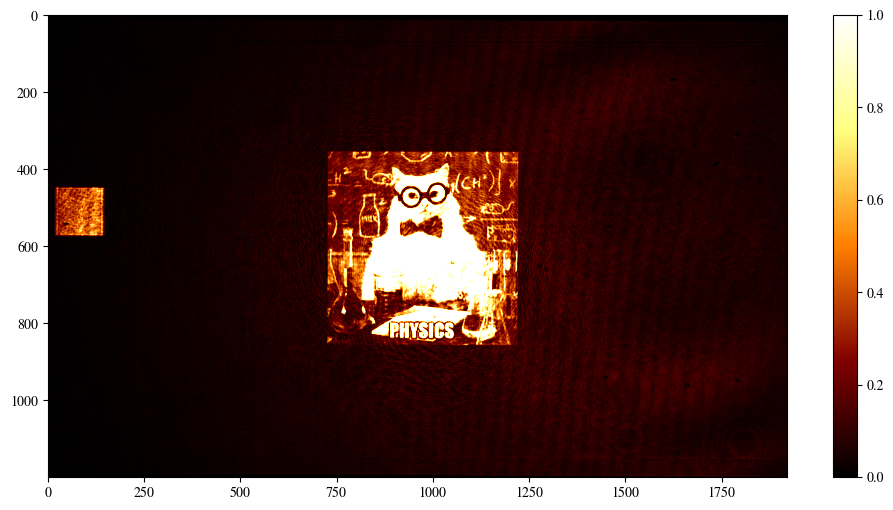

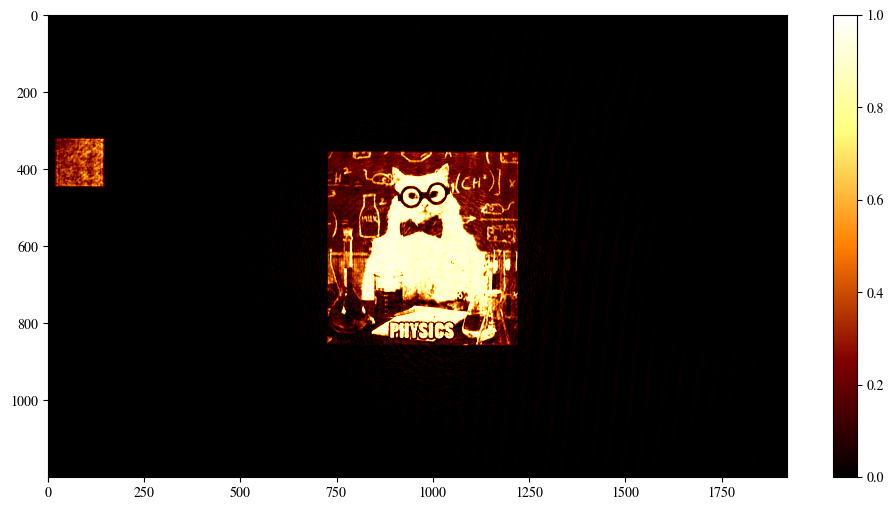

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(pic[0], cmap='afmhot', vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(pic[1], cmap='afmhot', vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

fig, ax = plt.subplots(figsize=(12,6))
im = ax.imshow(pic2, cmap='afmhot', vmin=0, vmax=1)
fig.colorbar(im)
plt.show()

In [ ]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000, img_size=(28, 28), device='cpu'):
    """ Loader function for the MINST dataset, either Digits or Fashion
    
    :param train_batch_size: size of the train batch size, defaults to 50000
    :type train_batch_size: int
    :param test_batch_size: size of the test batch size, defaults to 10000
    :type test_batch_size: int
    ...
    :raises [ErrorType]: [ErrorDescription]
    ...
    :return: Iterator for the train dataset loader, Iterator for the test dataset loader
    :rtype: DataLoader, DataLoader
    """

    transform = Compose([
        ToTensor(),
        Lambda(lambda x: x.reshape([1, 28, 28])),
        Lambda(lambda x: torchvision.transforms.Resize(size=img_size, antialias=True)(x)),
        Lambda(lambda x: x.mul(255).to(torch.uint8).to(device).contiguous()),
    ])

    train_data = MNIST('./data/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data,
                              batch_size=train_batch_size,
                              shuffle=True,
                              drop_last=True,
                              collate_fn=lambda x: list(map(lambda x: x.to(device), default_collate(x))))

    test_data = MNIST('./data/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data,
                             batch_size=test_batch_size,
                             shuffle=True,
                             drop_last=True,
                             collate_fn=lambda x: list(map(lambda x: x.to(device), default_collate(x))))

    return train_loader, test_loader

train_loader, test_loader = MNIST_loaders(64, 1, (128, 128), device=device)

In [ ]:
def display_stack(img_stack):
    img_stack = img_stack.reshape(1, 1, 1, 128, 128).swapaxes(2,3).reshape(1 * 128, 1 * 128)
    return img_stack

In [ ]:
camera_test = torch.zeros(10, *uD.get_screen_size(), device=device).to(torch.uint8).cuda().contiguous()
target_label = 0
for batch, (x, y) in enumerate(test_loader):
    if(target_label == y):
        img_stack = display_stack(x)
        src_size = img_stack.size()
        target_size = camera_test.size()
        camera_test[target_label, (target_size[1] - src_size[0])//2:(target_size[1] + src_size[0])//2, (target_size[2] - src_size[1])//2:(target_size[2] + src_size[1])//2] = img_stack
        target_label +=1

        if(y == 9):
            break

In [ ]:
cam_dev._sync_frame = False
gla = np.zeros(np.shape(cam_dev.capture_image()))
for i in range(10):
    uD.displayCUDA(camera_test)
    cam_dev._sync_frame = True
    for _ in camera_test:
        foo = cam_dev.capture_image()
    
    gla += foo

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(gla, cmap='afmhot')
plt.show()

In [ ]:
def test_capture_latency(big_list, threshold=72):
    cam_read = []
    
    # Display IMG
    uD.displayCUDA(big_list, sync_frame=True)

    # Read IMG
    cam_dev._sync_frame = True
    for k, img in enumerate(big_list):      
        cam_read.append(cam_dev.capture_image())

    return cam_read

big_list = camera_test*10# + camera_test
len(big_list)

In [ ]:
%lprun -u 1e-3 -f cam_dev.capture_image cam_read = test_capture_latency(big_list)

In [ ]:
for k, _ in enumerate(big_list[:10]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(big_list[k].detach().cpu(), cmap='afmhot')
    ax2.imshow(cam_read[k], cmap='afmhot')
    plt.show()

In [ ]:
def test_capture_latency(frames, threshold=64):
    cam_read = []

    # Display IMG
    start = time.time()*1000.0
    uD.displayCUDA(frames)

    diff_time = time.time()*1000.0 - start
    # Read IMG
    ## Get the timestamp value
    cam_dev._sync_frame = True
    for k, _ in enumerate(frames):
        cam_read.append(cam_dev.capture_image())

    return cam_read, diff_time

In [ ]:
N_frame = 64

ptr0 = uD.toCuda(image)
ptr1 = uD.toCuda(image2)

label = []
frames = torch.zeros(64, *uD.get_screen_size(), device=device).to(torch.uint8).cuda().contiguous()

for i in range(N_frame):
    if(i%2):
        frames[i,:,:] = ptr0
        label.append(40)
    else:
        frames[i,:,:] = ptr1
        label.append(-40)

df_sync_lst = []

N_trial = 10
for threshold in range(72, 73, 1):
    print("Threshold value:", threshold, 'ms')
    for n_trial in range(N_trial):
       
        mean_frame = []
        capture_frame, displayed_time = test_capture_latency(frames, threshold=threshold)
        for k, frame in enumerate(capture_frame):
            mean_frame.append(np.mean(frame))
            
        df_sync_lst.append([threshold, n_trial, displayed_time, np.correlate(mean_frame, label)[0]])

In [ ]:
%lprun -u 1e-3 -f cam_dev.capture_image cam_read = test_capture_latency(frames, threshold=threshold)

In [ ]:
plt.plot(mean_frame)
plt.plot(label)

In [ ]:
df_sync = pd.DataFrame(df_sync_lst, columns=['Threshold', 'Trial', 'LoadingTime', 'Correlation'])
df_sync['Correlation'] = (df_sync['Correlation'] > 0).astype(int)
df_sync['LoadingTime'] = df_sync['LoadingTime']
df_sync

In [ ]:
plt.figure()
plt.scatter(df_sync['Trial'], df_sync['LoadingTime']/df_sync['LoadingTime'].max(), label='LoadingTime')
plt.scatter(df_sync['Trial'], df_sync['Correlation'], label='Correlation')
plt.legend()
plt.show()

In [ ]:
import IPython
test_widget = ipywidgets.Image(format='jpeg', value=bgr8_to_jpeg(np.zeros((1,1))), width=500, height=300)
display(test_widget)

for k, frame in enumerate(capture_frame):
    update_widget(test_widget, frame)

In [14]:
# Maybe make this into a dictionnary
img_size = (56, 56) ## image size on the Screen sent to uD
slm_size = (56, 56) ## size of the mask
pat_pad = (12, 12) ## padding next to each image, must be even numbers
cam_pad = (0, 0)  ## Padding to add when capturing imagelet with the camera
batch_layout = (8, 8) ## nb of images
batch_stacks = 64 ## nb images in the queue for displaying, too high: increase batch size, risk of filling memory + bad learning , too low: slower

Niter_slm = 4

**uD-SLM calibration**

In [15]:
%%time
#cam_dev.reset_screen_trigger()
cal_widget = ipywidgets.Image(format='jpeg', value=bgr8_to_jpeg(np.zeros((1,1))), width=600, height=450)
cal_widget2 = ipywidgets.Image(format='jpeg', value=bgr8_to_jpeg(np.zeros((1,1))), width=600, height=450)
train_wid = ipywidgets.HBox([cal_widget, cal_widget2])
display(train_wid)

cal_dict, slm_xy_offsets = DispUtils.calibrate_screens(screens=[uD, slm], # List of screens to calibrate, the first one is the reference
                                                       cam_dev=cam_dev,
                                                       pat_size=[img_size, slm_size], # List of images size for each screens
                                                       pat_pad=pat_pad,
                                                       cam_pad=cam_pad,
                                                       batch_layout=batch_layout,
                                                       n_iteration=Niter_slm,
                                                       update_widget=[lambda x: update_widget(cal_widget, x), lambda x: update_widget(cal_widget2, x)],
                                                       thres_lst=[120, 10], kern_lst=[7, 13],  capture_ref=True)

if(Niter_slm):
    DispUtils.display_calibration(cal_dict, update_widget=lambda x: update_widget(cal_widget, x), keys=['uD-out', 'slm-out'], disp_border=False)

Calibrating screen 0...
Calibrating screen 1 ...
{'slm-in_size': (52, 52), 'slm-out_size': (58, 60), 'padding': (12, 12), 'batch': (8, 8), 'uD-in_size': (56, 56), 'uD-out_size': (56, 58)}
CPU times: user 7.79 s, sys: 5.5 s, total: 13.3 s
Wall time: 7.32 s


In [14]:
DispUtils.display_calibration(cal_dict, update_widget=lambda x: update_widget(cal_widget, x), keys=['uD-out', 'slm-out'], disp_border=False)

{'uD-in_size': (224, 224), 'uD-out_size': (218, 220), 'padding': (8, 12), 'batch': (4, 4)}


KeyError: 'slm-out'

In [ ]:
def plot_cirles(screen_dev, radius=1):
    # Display just a portion of the uD
    img_rgb = np.zeros(screen_dev.get_screen_size())
    for item in cal_dict['data'].values():
        cX, cY, rX, rY, xmin, xmax, ymin, ymax = item['uD-in'].values()
        cv2.ellipse(img_rgb, (cX, cY), (rX*radius, rY*radius), 0, 0, 360, (1.0, 1.0, 1.0), -1)

    return img_rgb

uD_img = plot_cirles(uD, radius=3)
slm_img = plot_cirles(slm, radius=1)

In [ ]:
%%time
slm.display(slm_img, sync_frame=True, CUDA2GL=False)
uD.display(uD_img, sync_frame=True, CUDA2GL=False)

pic = cam_dev.capture_image(sync_frame=True)

slm.display(slm_img*0, sync_frame=True, CUDA2GL=False)
uD.display(uD_img, sync_frame=True, CUDA2GL=False)

pic2 = cam_dev.capture_image(sync_frame=True)

In [ ]:
plt.figure()
plt.imshow(pic)
plt.show()

plt.figure()
plt.imshow(pic2)
plt.show()